In [205]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
pd.set_option('display.max_rows', None)

In [206]:
##### Setup #####
df = pd.read_csv("../data/data_ilr_transformed/combined_data__resid_with_time.csv")
print(f"Dataset succesfully imported. Shape: {df.shape}")
print(" - Number of experiments:", len(df["Experiment"].unique()))
print(" - Number of unique time points:", len(df["time"].unique()))

# Variables
original_DVs = ["ina", "na", "nna", "enna"]
ilr_columns = ['ilr1', 'ilr2', 'ilr3']
ilr_resid_columns = ['ilr1_residual', 'ilr2_residual', 'ilr3_residual']
control_columns = ['excluded', 'injustice', 'personal', 'violence']

Dataset succesfully imported. Shape: (19265, 21)
 - Number of experiments: 8
 - Number of unique time points: 15


## Feature Engineering

In [207]:
##### Feature Engineering #####
# Additional time-based feature: time point relative to the total duration for each participant
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Calculate mean and standard deviation per participant (ID) for each ilr column
for column_group in [ilr_columns, ilr_resid_columns]:
    for col in column_group:
        df[f'{col}_mean'] = df.groupby('ID')[col].transform('mean')
        df[f'{col}_std'] = df.groupby('ID')[col].transform('std')
        df[f'{col}_min'] = df.groupby('ID')[col].transform('min')
        df[f'{col}_max'] = df.groupby('ID')[col].transform('max')

# Moving Average or Exponential Moving Average (EMA)
window_size = 2
for col in ilr_resid_columns:
    df[f'{col}_moving_avg'] = df.groupby('ID')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df[f'{col}_ema'] = df.groupby('ID')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())
ilr_moving_avg_cols = ['ilr1_residual_moving_avg', 'ilr2_residual_moving_avg', 'ilr3_residual_moving_avg']
ilr_ema_cols = ['ilr1_residual_ema', 'ilr2_residual_ema', 'ilr3_residual_ema']

# Fourier transformation
fourier_components = 1
# Compute Fourier transform for each 'ilr' variable per participant
for column_group in [ilr_moving_avg_cols, ilr_ema_cols]:
    for col in column_group:
        def compute_fourier(x):
            fft_vals = np.fft.fft(x)
            # Retain only the first N components (real and imaginary parts)
            return np.hstack([fft_vals.real[:fourier_components], fft_vals.imag[:fourier_components]])

        # Apply Fourier transformation and store as separate columns
        fourier_df = (
            df.groupby('ID')[col]
            .apply(lambda x: compute_fourier(x.values))
            .apply(pd.Series)
            .rename(columns=lambda i: f'{col}_fourier_{i+1}')
        )

        # Add Fourier features back to the dataframe
        df = df.join(fourier_df, on='ID')

In [208]:
def compute_fourier(x):
    fft_vals = np.fft.fft(x)
    # Retain only the first N components (real and imaginary parts)
    return np.hstack([fft_vals.real[:2], fft_vals.imag[:2]])

# Apply Fourier transformation and store as separate columns
fourier_df = (
    df.groupby('ID')["ilr3_residual_ema"]
    .apply(lambda x: compute_fourier(x.values))
    .apply(pd.Series)
    .rename(columns=lambda i: f'{col}_2_fourier_{i+1}')
)

# Add Fourier features back to the dataframe
df = df.join(fourier_df, on='ID')

In [209]:
experiment_timepoints = df.groupby('Experiment')['time'].max()

# Map the maximum time values back to the original DataFrame
df['total_timepoints'] = df['Experiment'].map(experiment_timepoints)

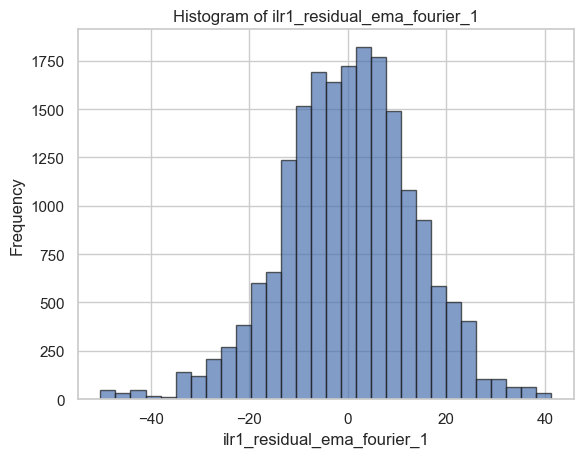

In [210]:
import matplotlib.pyplot as plt

variable = 'ilr1_residual_ema_fourier_1'
plt.hist(df[variable], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.title(f'Histogram of {variable}')
plt.show()


In [211]:
summary_table = df.describe().T[['mean', 'std', 'min', 'max']]
print(summary_table)

                                            mean         std        min  \
time                                6.619621e+00    4.023941   1.000000   
ID                                  7.170360e+02  472.867254   1.000000   
ina                                 5.847288e+00   17.458759   0.000000   
na                                  2.152593e+01   29.335168   0.000000   
nna                                 5.980509e+01   34.037772   0.000000   
enna                                1.289437e+01   23.398656   0.000000   
ilr1                                1.022723e+00    1.848018  -3.547032   
ilr2                                2.158309e+00    1.804457  -3.535202   
ilr3                               -7.767114e-01    1.863233  -3.404104   
excluded                            6.746480e-01    0.274247   0.000000   
injustice                           6.120555e-01    0.353733   0.000000   
personal                            6.281573e-01    0.278882   0.000000   
violence                 

In [212]:
##### Prepare Time Series Data for Clustering #####
time_series_data = []
grouped = df.groupby("ID")
feature_columns = [
    'relative_time',
    # 'total_timepoints',
    'ilr1_residual_mean', 'ilr2_residual_mean', # 'ilr3_residual_mean',
    'ilr1_residual_std', 'ilr2_residual_std', # 'ilr3_residual_std',
    'ilr1_residual_min', 'ilr2_residual_min', # 'ilr3_residual_min',
    'ilr1_residual_max', 'ilr2_residual_max', # 'ilr3_residual_max',

    # 'ilr1_deviation', 'ilr2_deviation', 'ilr3_deviation',
    # 'ilr1_moving_avg', 'ilr2_moving_avg', 'ilr3_moving_avg', 
    # 'ilr1_ema', 'ilr2_ema', 'ilr3_ema',
    #'ilr1_fourier_1', 'ilr2_fourier_1', 'ilr3_fourier_1',
    # 'ilr1_fourier_2', 'ilr2_fourier_2', 'ilr3_fourier_2'
    # 'ilr1_moving_avg_fourier_1', 'ilr2_moving_avg_fourier_1', 'ilr3_moving_avg_fourier_1',
    # 'ilr1_moving_avg_fourier_2', 'ilr2_moving_avg_fourier_2', 'ilr3_moving_avg_fourier_2',
    #'ilr3_residual_ema',

    # 'ilr1_residual_moving_avg_fourier_1', 'ilr2_residual_moving_avg_fourier_1', 'ilr3_residual_moving_avg_fourier_1',
    #'ilr1_residual_moving_avg_fourier_2', 'ilr2_residual_moving_avg_fourier_2', # 'ilr3_residual_moving_avg_fourier_2',

    'ilr1_residual_ema_fourier_1', 'ilr2_residual_ema_fourier_1', # 'ilr3_residual_ema_fourier_1',
    'ilr3_residual_ema_2_fourier_1', # 'ilr3_residual_ema_2_fourier_2', # 
    # 'ilr3_residual_ema_2_fourier_4'
    # 'ilr1_residual_ema_fourier_2', 'ilr2_residual_ema_fourier_2', 'ilr3_residual_ema_fourier_2'
]
print("====================")
print(f"{len(feature_columns)} features used:")
print(feature_columns)

feature_columns_to_scale = [
    #'relative_time',
    'ilr1_residual_mean', 'ilr2_residual_mean', 'ilr3_residual_mean',
    'ilr1_residual_std', 'ilr2_residual_std', 'ilr3_residual_std',
    'ilr1_residual_min', 'ilr2_residual_min', 'ilr3_residual_min',
    'ilr1_residual_max', 'ilr2_residual_max', 'ilr3_residual_max',
    'ilr1_residual_moving_avg_fourier_1', 'ilr2_residual_moving_avg_fourier_1', 'ilr3_residual_moving_avg_fourier_1',
    'ilr3_residual_ema',
    'ilr3_residual_ema_2_fourier_1', 'ilr3_residual_ema_2_fourier_2', 'ilr3_residual_ema_2_fourier_4'
    # 'ilr1_residual_moving_avg_fourier_2', 'ilr2_residual_moving_avg_fourier_2', 'ilr3_residual_moving_avg_fourier_2',
    # 'ilr1_residual_ema_fourier_1', 'ilr2_residual_ema_fourier_1', 'ilr3_residual_ema_fourier_1',
    # 'ilr1_residual_ema_fourier_2', 'ilr2_residual_ema_fourier_2', 'ilr3_residual_ema_fourier_2'
]
df[feature_columns_to_scale] = RobustScaler().fit_transform(df[feature_columns_to_scale])


12 features used:
['relative_time', 'ilr1_residual_mean', 'ilr2_residual_mean', 'ilr1_residual_std', 'ilr2_residual_std', 'ilr1_residual_min', 'ilr2_residual_min', 'ilr1_residual_max', 'ilr2_residual_max', 'ilr1_residual_ema_fourier_1', 'ilr2_residual_ema_fourier_1', 'ilr3_residual_ema_2_fourier_1']


In [213]:
# Preprocess the time series data for each participant
for participant, group in grouped:
    group_sorted = group.sort_values("time")
    time_series = group_sorted[feature_columns].values
    
    # Pad or truncate each participant's time series to the same length
    max_length = 15 # The 'time' in the Experiments ranges from 6 to 15
    if len(time_series) < max_length:
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        time_series = time_series[:max_length]
    
    time_series_data.append(time_series)

# Convert to numpy array for clustering
time_series_data = np.array(time_series_data)


##### Clustering #####
n_clusters = 3
print("====================")
print("Number of clusters:", n_clusters)
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(time_series_data)
# Adding labels to the original DataFrame for analysis:
df["cluster"] = df["ID"].map(dict(zip(grouped.groups.keys(), labels)))

# Create a summary of the number of participants from each experiment within each cluster
print("====================")
print("Clustering summaries:")
experiment_cluster_summary = df.groupby(['cluster', 'Experiment']).size().unstack(fill_value=0)
print(experiment_cluster_summary)

# Compute the cluster-wise percentages for each experiment
experiment_cluster_summary_percentages = experiment_cluster_summary.div(experiment_cluster_summary.sum(axis=0), axis=1) * 100
experiment_cluster_summary_percentages = experiment_cluster_summary_percentages.round(1)
print(experiment_cluster_summary_percentages)

# Count the number of participants in each cluster
cluster_counts = df["cluster"].value_counts()
print(cluster_counts)
cluster_summary = df.groupby("cluster")[["ina", "na", "nna", "enna", "ilr1", "ilr2", "ilr3"]].mean()
print(cluster_summary)



##### Evaluation (per study!) #####
silhouette_scores = []
davies_bouldin_scores = []

# Assume you have a variable `participant_ids` which stores the participant IDs in the exact order they appear in `time_series_data` and `labels`.
grouped = df.groupby("ID")
participant_ids = list(grouped.groups.keys())  # Ensure this matches the order used to build time_series_data
id_to_index = {pid: i for i, pid in enumerate(participant_ids)}
experiments = df['Experiment'].unique()

for exp in experiments:
    # Get participant IDs belonging to this experiment
    exp_ids = df.loc[df['Experiment'] == exp, 'ID'].unique()
    
    # Extract their original time series directly from df, no padding
    participant_series = []
    exp_labels = []
    
    for pid in exp_ids:
        # Extract participant's original data (sorted by time)
        p_data = df[df['ID'] == pid].sort_values('time')[feature_columns].values
        
        # Remove any rows that contain NaNs if present
        # (If your original dataset had no NaNs and you only introduced them via padding,
        # this step might not be necessary. But we keep it just in case.)
        p_data = p_data[~np.isnan(p_data).any(axis=1)]
        
        if len(p_data) == 0:
            # If a participant has no valid rows left, skip them (or handle differently)
            continue
        
        participant_series.append(p_data)
        
        # Retrieve the cluster label assigned to this participant
        # and store in exp_labels
        p_index = id_to_index[pid]
        exp_labels.append(labels[p_index])
        
    # Find the minimum length of sequences in this experiment
    lengths = [arr.shape[0] for arr in participant_series]
    min_len = min(lengths)
    print(f"Minimum length in Experiment {exp}: {min_len}")
    
    # Truncate all series to the minimal length
    truncated_series = [arr[:min_len] for arr in participant_series]
    
    # Flatten each participant's truncated time series into a single vector
    # Resulting shape: (n_participants, min_len * n_features)
    data_matrix = np.array([t.flatten() for t in truncated_series])
    exp_labels = np.array(exp_labels)
    
    # Compute Silhouette and Davies-Bouldin Scores
    # Note: These metrics are not DTW-based, but a simple Euclidean flattening.
    # If you want a DTW-based approach, you'd need a custom scoring function.
    try:
        sil = silhouette_score(data_matrix, exp_labels)
    except ValueError:
        sil = np.nan
    try:
        db = davies_bouldin_score(data_matrix, exp_labels)
    except ValueError:
        db = np.nan
    
    print(f"Experiment {exp}: Silhouette Score = {sil}, Davies-Bouldin Score = {db}")
    silhouette_scores.append(sil)
    davies_bouldin_scores.append(db)

# Calculating average and range
silhouette_avg = sum(silhouette_scores) / len(silhouette_scores)
davies_bouldin_avg = sum(davies_bouldin_scores) / len(davies_bouldin_scores)

print("silhouette_scores")
print("average:", silhouette_avg)
print("max:", max(silhouette_scores))
print("min:", min(silhouette_scores))

print("davies_bouldin_scores")
print("average:", davies_bouldin_avg)
print("max:", max(davies_bouldin_scores))
print("min:", min(davies_bouldin_scores))

Number of clusters: 3
Clustering summaries:
Experiment     1    2    3     4     5     6    7    8
cluster                                               
0            375  255  285  1035   350   136  147   42
1           1140  585  735  2505  1510  1120  826  456
2            870  660  660  2055  1550   960  714  294
Experiment     1     2     3     4     5     6     7     8
cluster                                                   
0           15.7  17.0  17.0  18.5  10.3   6.1   8.7   5.3
1           47.8  39.0  43.8  44.8  44.3  50.5  49.0  57.6
2           36.5  44.0  39.3  36.7  45.5  43.3  42.3  37.1
cluster
1    8877
2    7763
0    2625
Name: count, dtype: int64
               ina         na        nna       enna      ilr1      ilr2  \
cluster                                                                   
0        23.946667  11.007238  42.014857  23.031238 -0.624438  1.241135   
1         3.357441  11.483947  71.766137  13.392475  0.630079  2.856970   
2         2.574263  36

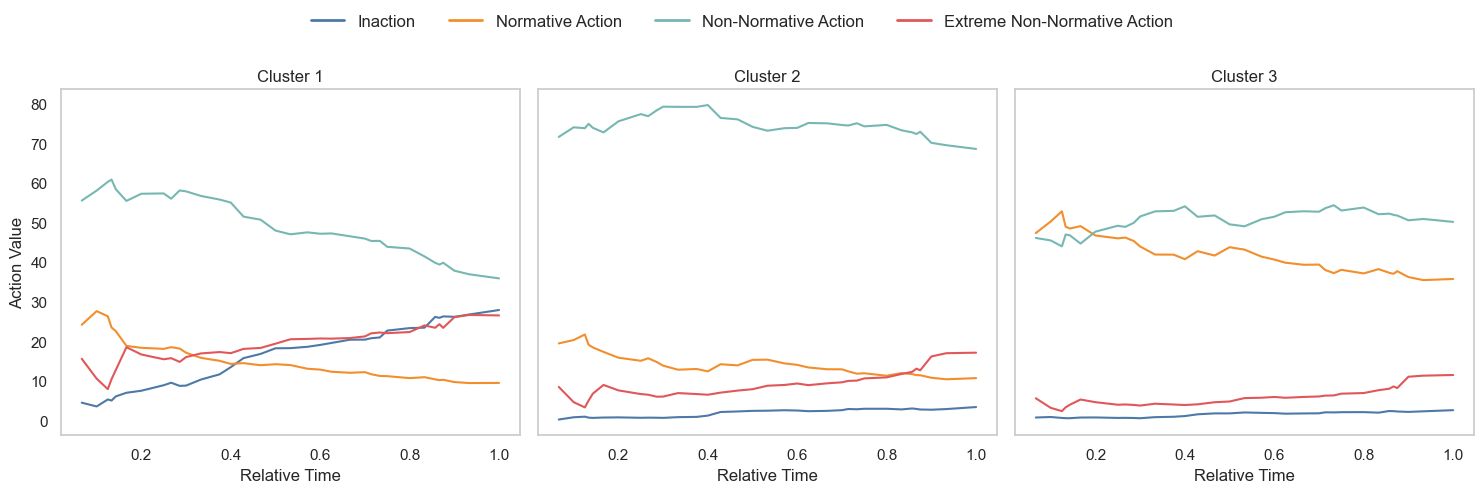

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

# Set Seaborn style
sns.set(style="whitegrid")

# Parameters
n_clusters = 3
alpha = 0.05  # Smoothing factor for EMA
savgol_window = 3  # Window length for Savitzky-Golay filter
savgol_polyorder = 1  # Polynomial order for Savitzky-Golay filter

# Set up a grid for side-by-side plots
fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5), sharey=True)

# Define colors for the action options
colors = {
    "ina": "#4E79A7",  # Muted Blue
    "na": "#F28E2B",  # Soft Orange
    "nna": "#76B7B2",  # Teal
    "enna": "#E15759",  # Soft Red
}

# Loop through clusters
for cluster, ax in enumerate(axes):
    cluster_data = df[df['cluster'] == cluster]
    mean_relative = cluster_data.groupby('relative_time')[['ina', 'na', 'nna', 'enna']].mean()
    
    # Apply Exponential Moving Average (EMA) smoothing
    mean_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # Plot EMA smoothed series for each action option
    for action, color in colors.items():
        ax.plot(
            mean_relative.index, mean_smooth_ema[action], 
            label=action, color=color, linestyle="-"
        )
    
    # Formatting for each subplot
    ax.set_title(f"Cluster {cluster + 1}")
    ax.set_xlabel("Relative Time")
    if cluster == 0:  # Add Y-axis label only to the first plot
        ax.set_ylabel("Action Value")
    ax.grid(False)

action_labels = {
    "ina": "Inaction",
    "na": "Normative Action",
    "nna": "Non-Normative Action",
    "enna": "Extreme Non-Normative Action",
}

fig.legend(
    handles=[plt.Line2D([0], [0], color=color, linestyle="-", lw=2) for color in colors.values()],
    labels=list(action_labels.values()),  # Use descriptive labels
    loc="upper center", ncol=4, frameon=False, fontsize=12
)

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space for the legend at the top
plt.show()